In [27]:
import pandas as pd
import numpy as np
from numpy import sort


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline
import folium

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import SelectFromModel


from xgboost import XGBClassifier
from xgboost import plot_importance


In [28]:
df = pd.read_csv('flint.csv')

In [29]:
df.rename(columns={'Year Built': 'YearBuilt'}, inplace=True)

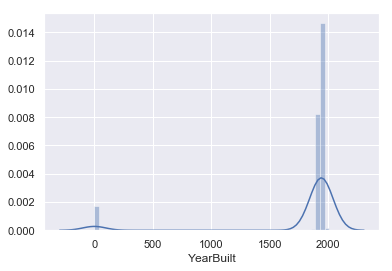

In [30]:
sns.set()

sns.distplot(df['YearBuilt'])

In [31]:
df['SL_Type'].value_counts()

1     1650
0      542
11     500
5      275
10       9
4        6
9        5
8        4
7        3
2        3
6        2
3        1
Name: SL_Type, dtype: int64

In [32]:
df.columns

Index(['Property Zip Code', 'Owner Type', 'Owner State', 'Homestead',
       'Homestead Percent', 'HomeSEV', 'Land Value', 'Land Improvements Value',
       'Residential Building Value', 'Residential Building Style',
       'Commercial Building Value', 'Building Storeys', 'Parcel Acres',
       'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'YearBuilt',
       'USPS Vacancy', 'Zoning', 'Future Landuse', 'DRAFT Zone',
       'Housing Condition 2012', 'Housing Condition 2014',
       'Commercial Condition 2013', 'Latitude', 'Longitude', 'Hydrant Type',
       'Ward', 'PRECINCT', 'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2',
       'Ed_July', 'Ed_March', 'Last_Test', 'Max_Lead', 'Med_Lead', 'Num_Tests',
       'Res_Test', 'Sen_Test', 'SL_private_inspection',
       'B_median_age_all_women', 'B_median_age_all_men', 'B_median_age_all',
       'B_median_age_all_women_white', 'B_median_age_all_men_white',
       'B_median_age_all_white', 'B_median_age_all_women_black',
       'B_media

In [33]:
df['SL_private_inspection'].fillna('Iron', inplace=True)
df.loc[ (~df['SL_private_inspection'].isin(['Lead', 'Galvanized'])), 'SL_private_inspection' ] = False

In [34]:
df['B_imputed_rent'].fillna(0, inplace=True) 
df['B_imputed_value'].fillna(0, inplace=True) 

In [35]:
df['SL_Lead'] = False
df.loc[ (df['sl_public_type'].isin (['LEAD','GALVANIZED']) ) | (df['sl_private_type'].isin(['LEAD','GALVANIZED']) ), 'SL_Lead' ] = True

In [36]:
df['SL_Lead'].value_counts()

False    1709
True     1291
Name: SL_Lead, dtype: int64

In [37]:
#Uncomment below lines to run with 37 features selected

features_df = df[['YearBuilt', 'Residential Building Value', 'Land Value',
       'Commercial Building Value', 'Parcel Acres', 'YearBuilt', 'Building Storeys',
                  'Rental', 'Use Type', 'Prop Class', 'Old Prop class',
                  'Res_Test', 'Sen_Test', 'SL_private_inspection',
                  'Commercial Condition 2013', 'Latitude', 'Longitude', 'Hydrant Type',
                         'USPS Vacancy', 'Zoning', 'Future Landuse', 'DRAFT Zone',
                         'Ward', 'PRECINCT', 'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2',
                         'Ed_July', 'Ed_March', 'Last_Test', 'Max_Lead', 'Med_Lead', 'Num_Tests',
                        'B_imputed_value',
                  'B_total_black_pop', 'B_total_white_pop',
                  'SL_Lead']].copy()

#Uncomment below lines to run with only five features selected
#features_df = df[['YearBuilt', 'SL_Type', 'Latitude', 'Residential Building Value', 'Longitude',
#                  'SL_Lead']].copy()

#Uncomment below lines to run with only two features
#features_df = df[['YearBuilt', 'Latitude',
#                  'SL_Lead']].copy()


features_df['Age'] = 2019 - df['YearBuilt']
features_df = features_df.drop(columns='YearBuilt', axis=1)

list(features_df.columns)

######### Features that seem to reduce accuracy
# 'B_imputed_rent',
#                         'B_median_age_all_women', 'B_median_age_all_men', 'B_median_age_all',
#      'B_median_age_all_women_white', 'B_median_age_all_men_white',
#       'B_median_age_all_white', 'B_median_age_all_women_black',
#                  'Property Zip Code',


['Residential Building Value',
 'Land Value',
 'Commercial Building Value',
 'Parcel Acres',
 'Building Storeys',
 'Rental',
 'Use Type',
 'Prop Class',
 'Old Prop class',
 'Res_Test',
 'Sen_Test',
 'SL_private_inspection',
 'Commercial Condition 2013',
 'Latitude',
 'Longitude',
 'Hydrant Type',
 'USPS Vacancy',
 'Zoning',
 'Future Landuse',
 'DRAFT Zone',
 'Ward',
 'PRECINCT',
 'CENTRACT',
 'CENBLOCK',
 'SL_Type',
 'SL_Type2',
 'Ed_July',
 'Ed_March',
 'Last_Test',
 'Max_Lead',
 'Med_Lead',
 'Num_Tests',
 'B_imputed_value',
 'B_total_black_pop',
 'B_total_white_pop',
 'SL_Lead',
 'Age']

In [45]:
Y = features_df['SL_Lead']
X = features_df.drop(columns='SL_Lead', axis=1)

enc_X = pd.get_dummies(X)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(enc_X, Y, test_size = 0.3, random_state = 2018,stratify = Y)

Xtest.shape
Xtrain.shape

(2100, 97)

In [44]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)
y_pred = dt.predict(Xtest)

print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

np.sum(Ytest)/len(Ytest)


cm = confusion_matrix(Ytest, y_pred)
print('\nConfusion Matrics\n', pd.DataFrame(cm))

Accuracy is  0.8833333333333333
Precision is  0.8615384615384616
Recall is  0.8682170542635659

Confusion Matrics
      0    1
0  459   54
1   51  336


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_features=2)
rf.fit(Xtrain, Ytrain)
y_pred = rf.predict(Xtest)
y_prob = rf.predict_proba(Xtest)

print('Accuracy Matrics\n')
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

np.sum(Ytest)/len(Ytest)

cm = confusion_matrix(Ytest, y_pred)
print('\nConfusion Matrics\n', pd.DataFrame(cm))

Accuracy Matrics

Accuracy is  0.9166666666666666
Precision is  0.8732057416267942
Recall is  0.9431524547803618

Confusion Matrics
      0    1
0  460   53
1   22  365


Accuracy Matrics

Accuracy is  0.9277777777777778
Precision is  0.9065656565656566
Recall is  0.9276485788113695

Confusion Matrics
      0    1
0  476   37
1   28  359


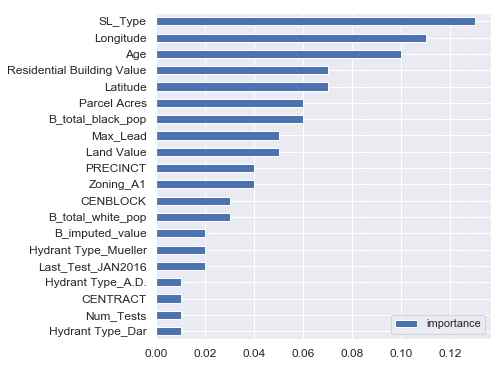

In [41]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators = 100, random_state=2018, learning_rate = 0.5)
adaboost.fit(Xtrain, Ytrain)
y_pred = adaboost.predict(Xtest)
y_prob = adaboost.predict_proba(Xtest)

print('Accuracy Matrics\n')
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

importances = adaboost.feature_importances_
imp_df = pd.DataFrame({'variable': Xtrain.columns.tolist(), 'importance': importances})
# create dataframe with top 10 by variable importance
df_top = imp_df.nlargest(20, columns = ['importance'], keep='first').sort_values(by = 'importance', ascending = True)
labs = df_top['variable']

df_top.plot.barh(fontsize = 12,  figsize = (6,6)).set_yticklabels(labs, rotation=0)

cm = confusion_matrix(Ytest, y_pred)
print('\nConfusion Matrics\n', pd.DataFrame(cm))

Accuracy Matrics

Accuracy is  0.9344444444444444
Precision is  0.9
Recall is  0.9534883720930233

Confusion Matrics
      0    1
0  472   41
1   18  369


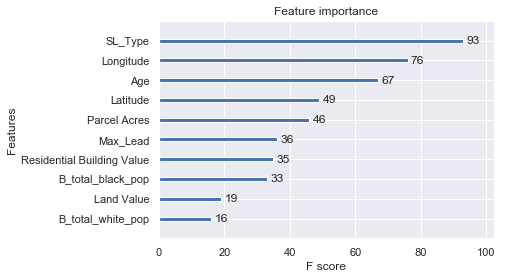

In [46]:
model = XGBClassifier()
model.fit(Xtrain, Ytrain)


# make predictions for test data
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]

print('Accuracy Matrics\n')
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

cm = confusion_matrix(Ytest, y_pred)
print('\nConfusion Matrics\n', pd.DataFrame(cm))

plot_importance(model, max_num_features=10,)

#Xtrain.columns.value_counts()

In [26]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(Xtrain)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, Ytrain)
	# eval model
	select_X_test = selection.transform(Xtest)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(Ytest, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
Thresh=0.000, n=97, Accuracy: 93.44%
T